## Basic Imports

In [ ]:
import gc
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pandas as pd

%matplotlib inline

from tensorflow.keras import backend as K # Importing Keras backend (by default it is Tensorflow)
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.layers import Input, Conv2D, Dense, Dropout, Flatten, MaxPool2D # Layers to be used for building our model
from tensorflow.keras.models import Model # The class used to create a model
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.utils import to_categorical
from tensorflow.random import set_seed
from tensorflow.keras.callbacks import EarlyStopping # Callback for early stopping
print("Tensorflow version " + tf.__version__)

Tensorflow version 2.8.0


## Data Import and Basic Functions

In [ ]:
classes = 10

(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
Y_train = to_categorical(y_train, classes)
Y_test = to_categorical(y_test, classes)

4431872/4422102 [==============================] - 0s 0us/step


In [ ]:
def plot_history(hs, epochs, metric):
    print()
    plt.style.use('dark_background')
    plt.rcParams['figure.figsize'] = [15, 8]
    plt.rcParams['font.size'] = 16
    plt.clf()
    for label in hs:
        plt.plot(hs[label].history[metric], label='{0:s} train {1:s}'.format(label, metric), linewidth=2)
        plt.plot(hs[label].history['val_{0:s}'.format(metric)], label='{0:s} validation {1:s}'.format(label, metric), linewidth=2)
    x_ticks = np.arange(0, epochs + 1, epochs / 10)
    x_ticks [0] += 1
    plt.xticks(x_ticks)
    plt.ylim((0, 1))
    plt.xlabel('Epochs')
    plt.ylabel('Loss' if metric=='loss' else 'Accuracy')
    plt.legend()
    plt.show()

In [ ]:
def evaluation_plot(hs,eval):
  print("Train Loss     : {0:.5f}".format(hs.history['loss'][-1]))
  print("Validation Loss: {0:.5f}".format(hs.history['val_loss'][-1]))
  print("Test Loss      : {0:.5f}".format(eval[0]))
  print("---")
  print("Train Accuracy     : {0:.5f}".format(hs.history['accuracy'][-1]))
  print("Validation Accuracy: {0:.5f}".format(hs.history['val_accuracy'][-1]))
  print("Test Accuracy      : {0:.5f}".format(eval[1]))

  # Plot train and validation error per epoch.
  plot_history(hs={ 'MLP': hs}, epochs=epochs, metric='loss')
  plot_history(hs={'MLP': hs}, epochs=epochs, metric='accuracy')

## Model Architecture

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    verbose=1,
    restore_best_weights=True
)


In [ ]:
def train_model(
        train_data,
        train_labels,
        optimizer,
        epochs=100,
        batch_size=128,
        hidden_layers=1,
        hidden_activation='relu',
        output_activation='softmax',

        callbacks = None,
        verbose=0):
    
    np.random.seed(1402) # Define the seed for numpy to have reproducible experiments.
    set_seed(1981) # Define the seed for Tensorflow to have reproducible experiments.
    
    # Define the input layer.
    input = Input(
        shape=(784,),
        name='Input'
    )

    x = input
    # Define the remaining hidden layers.
    for i in range(hidden_layers):
        x = Dense(
            units=256,
            kernel_initializer=tf.keras.initializers.HeUniform(),#'glorot_uniform',
            activation=hidden_activation,
            name='Hidden-{0:d}'.format(i + 1)
        )(x)
        x = Dropout(
                rate=0.2,
                name='Dropout-{0:d}'.format(i + 1)
            )(x)
    # Define the output layer.
    output = Dense(
        units=classes,
        kernel_initializer=tf.keras.initializers.HeUniform(),#'glorot_uniform',
        activation=output_activation,
        name='Output'
    )(x)
    
    # Define the model and train it.
    model = Model(inputs=input, outputs=output)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    hs = model.fit(
        x=X_train,
        y=Y_train,
        validation_split=0.1, # use 10% of the training data as validation data
        epochs=epochs,
        verbose=verbose,
        callbacks = [callbacks],
        batch_size=batch_size
    )
    print('Finished training.')
    print('------------------')
    #model.summary() # Print a description of the model.
    return model,hs


## MLP Model with 2 hidden layers - Tuning and Evaluation

Testing model for best Batch Size and Optimizer


In [ ]:
tune = pd.DataFrame(columns=('Optimizer','Learning_Rate', 'Batch_Size','Train_Loss','Val_Loss','Test_Loss','Train_Accuracy','Val_Accuracy','Test_Accuracy'))
optimizer = [Adam(learning_rate=0.001),SGD(learning_rate = 0.1),Adam(learning_rate=0.0001),SGD(learning_rate = 0.01)]
batch_size = [128,256,512]
cnt = 0
for i in batch_size:
  for opt in optimizer:
    # MLP
    model, hs = train_model(
        train_data=X_train,
        train_labels=Y_train,
        optimizer=opt,
        epochs=100,
        batch_size=i,
        hidden_layers=2,
        hidden_activation='relu',
        output_activation='softmax',
        callbacks = [early_stopping]
    )

    # Evaluate on test data and show all the results.
    eval = model.evaluate(X_test, Y_test, verbose=1)
    tune.loc[cnt] = [opt._name,opt.learning_rate.numpy(),i,hs.history['loss'][-1],hs.history['val_loss'][-1],eval[0],hs.history['accuracy'][-1],hs.history['val_accuracy'][-1],eval[1]]
    cnt += 1


Restoring model weights from the end of the best epoch: 35.
Epoch 45: early stopping
Finished training.
------------------
313/313 [==============================] - 1s 3ms/step - loss: 0.3410 - accuracy: 0.8929
Restoring model weights from the end of the best epoch: 33.
Epoch 43: early stopping
Finished training.
------------------
313/313 [==============================] - 1s 3ms/step - loss: 0.3133 - accuracy: 0.8913
Restoring model weights from the end of the best epoch: 49.
Epoch 59: early stopping
Finished training.
------------------
313/313 [==============================] - 1s 3ms/step - loss: 0.3153 - accuracy: 0.8929
Restoring model weights from the end of the best epoch: 80.
Epoch 90: early stopping
Finished training.
------------------
313/313 [==============================] - 1s 3ms/step - loss: 0.3322 - accuracy: 0.8801
Restoring model weights from the end of the best epoch: 43.
Epoch 53: early stopping
Finished training.
------------------
313/313 [====================

In [ ]:
tune.sort_values("Test_Accuracy",ascending=False)

,Optimizer,Learning_Rate,Batch_Size,Train_Loss,Val_Loss,Test_Loss,Train_Accuracy,Val_Accuracy,Test_Accuracy
8,Adam,0.0010,512,0.171049,0.310474,0.307544,0.934296,0.897167,0.8951
4,Adam,0.0010,256,0.161893,0.338903,0.336052,0.937574,0.894000,0.8937
0,Adam,0.0010,128,0.159727,0.338039,0.340994,0.938944,0.897500,0.8929
2,Adam,0.0001,128,0.170257,0.300050,0.315331,0.937944,0.896167,0.8929
1,SGD,0.1000,128,0.194522,0.297791,0.313302,0.926704,0.893500,0.8913
10,Adam,0.0001,512,0.192273,0.293183,0.312733,0.930333,0.895667,0.8903
6,Adam,0.0001,256,0.177528,0.296477,0.311040,0.934444,0.894833,0.8901
9,SGD,0.1000,512,0.195646,0.298253,0.313399,0.928037,0.893833,0.8896
5,SGD,0.1000,256,0.228646,0.304168,0.316641,0.916222,0.884833,0.8879
3,SGD,0.0100,128,0.274412,0.306335,0.332232,0.901648,0.885167,0.8801


Restoring model weights from the end of the best epoch: 15.
Epoch 25: early stopping
Finished training.
------------------
313/313 [==============================] - 1s 3ms/step - loss: 0.3153 - accuracy: 0.8901
Train Loss     : 0.20511
Validation Loss: 0.31105
Test Loss      : 0.31527
---
Train Accuracy     : 0.92261
Validation Accuracy: 0.89233
Test Accuracy      : 0.89010



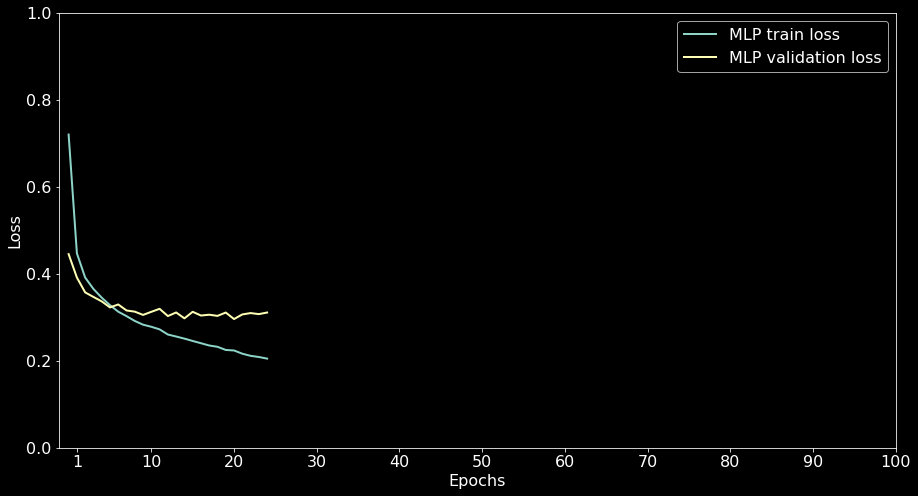

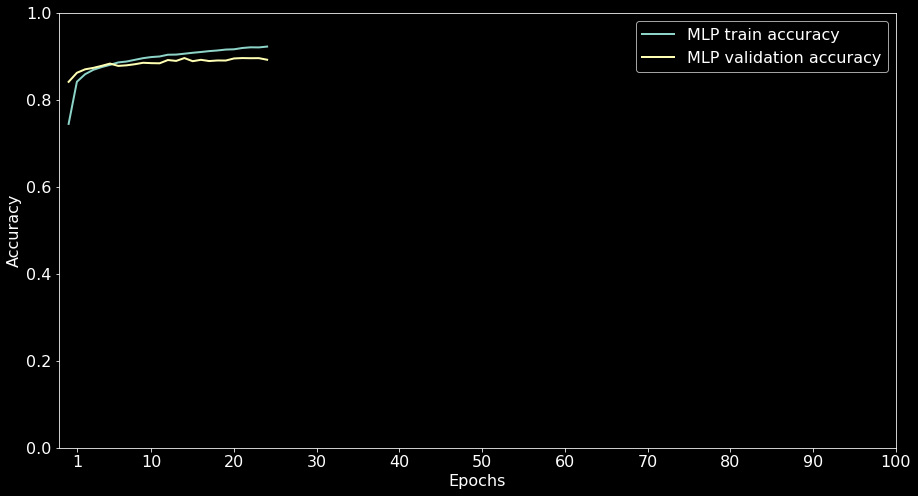

In [ ]:
#model with best results

optimizer = Adam(learning_rate=0.001)
batch_size=512
epochs = 100
# MLP
model, hs = train_model(
    train_data=X_train,
    train_labels=Y_train,
    optimizer=optimizer,
    epochs=epochs,
    batch_size=batch_size,
    hidden_layers=2,
    hidden_activation='relu',
    output_activation='softmax',
    callbacks = [early_stopping]
)

# Evaluate on test data and show all the results.
eval = model.evaluate(X_test, Y_test, verbose=1)
evaluation_plot(hs,eval)

In [ ]:
model.summary()

Model: "model_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 784)]             0         
                                                                 
 Hidden-1 (Dense)            (None, 256)               200960    
                                                                 
 Dropout-1 (Dropout)         (None, 256)               0         
                                                                 
 Hidden-2 (Dense)            (None, 256)               65792     
                                                                 
 Dropout-2 (Dropout)         (None, 256)               0         
                                                                 
 Output (Dense)              (None, 10)                2570      
                                                                 
Total params: 269,322
Trainable params: 269,322
Non-traina

## MLP Model with 3 hidden layers - Tuning and Evaluation

In [ ]:
tune_2 = pd.DataFrame(columns=('Optimizer','Learning_Rate', 'Batch_Size','Train_Loss','Val_Loss','Test_Loss','Train_Accuracy','Val_Accuracy','Test_Accuracy'))
optimizer = [Adam(learning_rate=0.001),SGD(learning_rate = 0.1),Adam(learning_rate=0.0001),SGD(learning_rate = 0.01)]
batch_size = [128,256,512]
cnt = 0
for i in batch_size:
  for opt in optimizer:
    # MLP
    model, hs = train_model(
        train_data=X_train,
        train_labels=Y_train,
        optimizer=opt,
        epochs=100,
        batch_size=i,
        hidden_layers=3,
        hidden_activation='relu',
        output_activation='softmax',
        callbacks = [early_stopping]
    )

    # Evaluate on test data and show all the results.
    eval = model.evaluate(X_test, Y_test, verbose=1)
    tune_2.loc[cnt] = [opt._name,opt.learning_rate.numpy(),i,hs.history['loss'][-1],hs.history['val_loss'][-1],eval[0],hs.history['accuracy'][-1],hs.history['val_accuracy'][-1],eval[1]]
    cnt += 1

Restoring model weights from the end of the best epoch: 25.
Epoch 35: early stopping
Finished training.
------------------
313/313 [==============================] - 1s 3ms/step - loss: 0.3187 - accuracy: 0.8932
Restoring model weights from the end of the best epoch: 41.
Epoch 51: early stopping
Finished training.
------------------
313/313 [==============================] - 1s 3ms/step - loss: 0.3159 - accuracy: 0.8908
Restoring model weights from the end of the best epoch: 71.
Epoch 81: early stopping
Finished training.
------------------
313/313 [==============================] - 1s 3ms/step - loss: 0.3531 - accuracy: 0.8966
Finished training.
------------------
313/313 [==============================] - 1s 3ms/step - loss: 0.3289 - accuracy: 0.8861
Restoring model weights from the end of the best epoch: 49.
Epoch 59: early stopping
Finished training.
------------------
313/313 [==============================] - 1s 3ms/step - loss: 0.3466 - accuracy: 0.8893
Restoring model weights f

In [ ]:
tune_2.sort_values("Test_Accuracy",ascending=False)

,Optimizer,Learning_Rate,Batch_Size,Train_Loss,Val_Loss,Test_Loss,Train_Accuracy,Val_Accuracy,Test_Accuracy
2,Adam,0.0001,128,0.122518,0.354204,0.353139,0.952944,0.897833,0.8966
8,Adam,0.0010,512,0.184589,0.317770,0.322340,0.930963,0.893833,0.8940
0,Adam,0.0010,128,0.199642,0.319874,0.318674,0.924148,0.893833,0.8932
6,Adam,0.0001,256,0.164193,0.324472,0.328093,0.939241,0.894167,0.8911
1,SGD,0.1000,128,0.188838,0.332262,0.315868,0.928389,0.893000,0.8908
10,Adam,0.0001,512,0.191818,0.307590,0.321397,0.928444,0.893333,0.8906
5,SGD,0.1000,256,0.184645,0.341030,0.322307,0.929500,0.891333,0.8905
4,Adam,0.0010,256,0.179636,0.339120,0.346552,0.932093,0.891000,0.8893
9,SGD,0.1000,512,0.210672,0.339953,0.320931,0.920889,0.887333,0.8873
3,SGD,0.0100,128,0.248173,0.308503,0.328898,0.908574,0.890333,0.8861


Restoring model weights from the end of the best epoch: 31.
Epoch 41: early stopping
Finished training.
------------------
313/313 [==============================] - 1s 3ms/step - loss: 0.3235 - accuracy: 0.8922
Train Loss     : 0.18844
Validation Loss: 0.32036
Test Loss      : 0.32351
---
Train Accuracy     : 0.92976
Validation Accuracy: 0.89550
Test Accuracy      : 0.89220



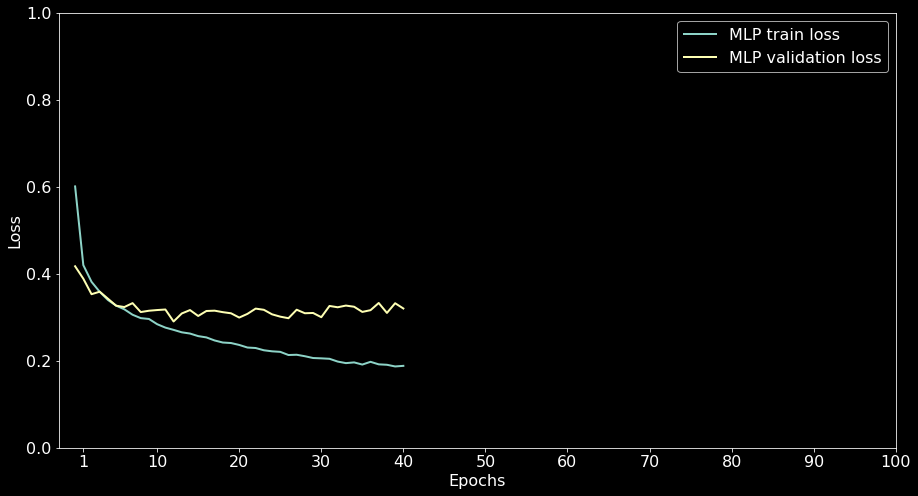

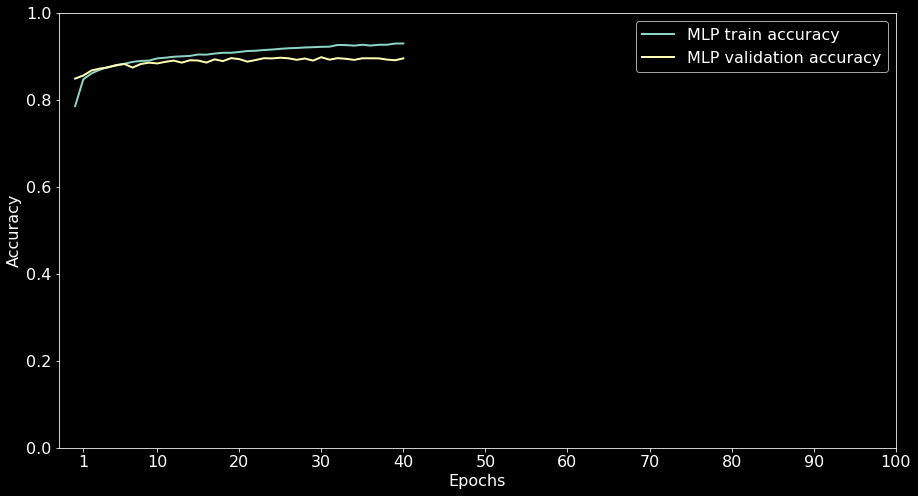

In [ ]:
#model with best results

optimizer = Adam(learning_rate=0.001)
batch_size=128
epochs = 100
# MLP
model, hs = train_model(
    train_data=X_train,
    train_labels=Y_train,
    optimizer=optimizer,
    epochs=epochs,
    batch_size=batch_size,
    hidden_layers=3,
    hidden_activation='relu',
    output_activation='softmax',
    callbacks = [early_stopping]
)

# Evaluate on test data and show all the results.
eval = model.evaluate(X_test, Y_test, verbose=1)
evaluation_plot(hs,eval)

In [ ]:
model.summary()

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 784)]             0         
                                                                 
 Hidden-1 (Dense)            (None, 256)               200960    
                                                                 
 Dropout-1 (Dropout)         (None, 256)               0         
                                                                 
 Hidden-2 (Dense)            (None, 256)               65792     
                                                                 
 Dropout-2 (Dropout)         (None, 256)               0         
                                                                 
 Hidden-3 (Dense)            (None, 256)               65792     
                                                                 
 Dropout-3 (Dropout)         (None, 256)               0  